### Dataset And Model Downloads

In [ ]:
# https://www.kaggle.com/datasets/maamri95/cdnet2014

# Download the archive and extract it in the code src folder.
# (or)
# Download archive.zip from this Drive link:
"https://drive.google.com/drive/folders/1nhLOLUpfUIZFIzi29aNueD7zo6ToJ7iA?usp=sharing"
# Make sure that the dataset is present in this folder structure archive\dataset\dynamicBackground\fall\input after extraction.

In [1]:
# Yolo Model Download for Linux users:
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

# Google Drive link for these files(Windows):
"https://drive.google.com/drive/folders/1nhLOLUpfUIZFIzi29aNueD7zo6ToJ7iA?usp=sharing"

# Note: the yolo model related files are present in the Model and Weights folder.
# Place these files in the src folder before running the code.

--2025-04-20 14:46:36--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2025-04-20 14:46:36 (16.6 MB/s) - ‘yolov3.cfg’ saved [8342/8342]

--2025-04-20 14:46:36--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 104.21.88.156, 172.67.185.199, 2606:4700:3037::6815:589c, ...
Connecting to pjreddie.com (pjreddie.com)|104.21.88.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘yolov3.weights’

yolov3.weights          [ <=>                ]   8.80K  --.-KB/s  

'https://drive.google.com/drive/folders/1nhLOLUpfUIZFIzi29aNueD7zo6ToJ7iA?usp=sharing'

### Base Paper Implementation:

In [ ]:
# The code can be run using CdNet dataset or with our own video/use any of the videos present in the drive link in Custom_Videos folder.

import cv2
import os
import numpy as np
import torch
from collections import deque

# Parameters
OVERLAY_THRESHOLD = 300        # Number of frames in the sliding window
SKIP_OVERLAY_FRAME = 1        # Skip frames to reduce redundancy
CHANGE_THRESHOLD = 0.2         # Threshold to update background pixel
SUPPORTED_EXTENSIONS = ('.jpg', '.png')

# Device setup: Using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# YOLO Model Loading
def load_yolo_model():
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)  # Run YOLO on CPU to save GPU memory
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    return net, output_layers

# Background Estimation with Sliding Window
def estimate_background_sliding_window(sequence_path, save_path, yolo_net, output_layers):
    frame_files = sorted([f for f in os.listdir(sequence_path) if f.endswith(SUPPORTED_EXTENSIONS)])

    if len(frame_files) == 0:
        print(f"No frames found in {sequence_path}")
        return

    print(f"Processing {len(frame_files)} frames in: {sequence_path}")

    overlay_frames = None
    frame_index = 0
    estimation_background = None

    for idx, filename in enumerate(frame_files):
        if idx % SKIP_OVERLAY_FRAME != 0:
            continue

        frame_path = os.path.join(sequence_path, filename)
        frame = cv2.imread(frame_path)
        if frame is None:
            continue

        # Optional downscale to save memory
        # frame = cv2.resize(frame, (640, 360))  # Uncomment to resize

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        with torch.no_grad():
            gray_tensor = torch.from_numpy(gray_frame).to(device)

            if overlay_frames is None:
                height, width = gray_tensor.shape
                overlay_frames = torch.zeros((OVERLAY_THRESHOLD, height, width), dtype=torch.uint8, device=device)
                estimation_background = torch.zeros((height, width), dtype=torch.uint8, device=device)

            overlay_frames[frame_index % OVERLAY_THRESHOLD] = gray_tensor
            frame_index += 1

            if frame_index < OVERLAY_THRESHOLD:
                continue

            # Use mode to find dominant pixel value
            dominant_values = torch.mode(overlay_frames, dim=0).values.byte()

            # Update background selectively
            change = (estimation_background.to(torch.float32) - dominant_values.to(torch.float32)).abs() / 255.0
            update_mask = change > CHANGE_THRESHOLD
            estimation_background[update_mask] = dominant_values[update_mask]
            # Cleanup per frame
            del gray_tensor, dominant_values, change, update_mask
            torch.cuda.empty_cache()

        # Run YOLO object detection on CPU
        boxes_dir = os.path.join(save_path, "boxes")
        os.makedirs(boxes_dir, exist_ok=True)
        output_frame_result_boxes_text_path = os.path.join(boxes_dir, f"frame_{idx:04d}_detected.txt")
        # os.makedirs(output_frame_result_boxes_text_path, exist_ok=True)
        detected_frame, result_boxes = detect_objects_with_yolo(frame, yolo_net, output_layers, save_txt_path=str(output_frame_result_boxes_text_path))
        save_path1 = os.path.join(save_path, "detections")
        os.makedirs(save_path1, exist_ok=True)
        output_frame_name = os.path.join(save_path1, f"frame_{idx:04d}_detected.jpg")
        cv2.imwrite(output_frame_name, detected_frame)
        print(f"Saved detected frame at: {output_frame_name}")

        # cv2.imshow("Background", estimation_background.cpu().numpy())
        # cv2.waitKey(1)

    # Save final background
    os.makedirs(save_path, exist_ok=True)
    bg_np = estimation_background.cpu().numpy()
    output_path = os.path.join(save_path, "background.jpg")
    cv2.imwrite(output_path, bg_np)
    print(f"Saved estimated background at: {output_path}")
    # # Run YOLO object detection on CPU
    bg_detect_output_path = os.path.join(save_path, "background_detections.txt")
    bg_detected_img, _ = detect_objects_with_yolo(
        cv2.cvtColor(bg_np, cv2.COLOR_GRAY2BGR),
        yolo_net,
        output_layers,
        save_txt_path=bg_detect_output_path
    )
    cv2.imwrite(os.path.join(save_path, "background_yolo.jpg"), bg_detected_img)
    return bg_np


# YOLO Object Detection
def detect_objects_with_yolo(frame, net, output_layers, save_txt_path=None):
    # Load class names
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]

    height, width, _ = frame.shape

    # YOLO input blob
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    detections = net.forward(output_layers)

    class_ids, confidences, boxes = [], [], []

    # Parse detections
    for out in detections:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    result_boxes = []
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            cls_id = class_ids[i]
            result_boxes.append((x, y, w, h, cls_id))
            # Draw box on frame
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, f"{classes[cls_id]}", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Optional: Save to .txt
    if save_txt_path is not None:
        with open(save_txt_path, 'w') as f:
            for box in result_boxes:
                f.write(f"{box[0]} {box[1]} {box[2]} {box[3]} {box[4]}\n")

    return frame, result_boxes

# Run on Multiple Sequences
def process_all_sequences(dataset_root, sequences, result_dir, yolo_net, output_layers):
    for seq in sequences:
        full_path = os.path.join(dataset_root, seq, "input")
        if not os.path.exists(full_path):
            print(f"Sequence not found: {full_path}")
            continue
        # Create a result directory based on the sequence name
        sequence_name = os.path.basename(seq)
        result_sequence_path = os.path.join(result_dir, sequence_name+"\\grayscale")
        # Ensure the result directory for the sequence exists
        os.makedirs(result_sequence_path, exist_ok=True)
        # Estimate background and save results to the corresponding folder
        estimate_background_sliding_window(full_path, result_sequence_path, yolo_net, output_layers)

###Code to find background using grayscale histogram method for our custom video.

In [ ]:
import cv2
import os
import shutil

# Define path to the uploaded video
# video_path = "data_video.mp4"  # Change this to your uploaded file name
# video_path = "elevated-view-looking-along-42nd-street.mp4"  # Change this to your uploaded file name
# video_path = "videoblocks-busy-street-junction.mp4"  # Change this to your uploaded file name
# video_path = "videoblocks-timelapse-of-nypd-police-car.mp4"  # Change this to your uploaded file name
# video_path = "videoblocks-moe_P360.mp4"  # Change this to your uploaded file name
# video_path = "neon-lights-of-42nd-street-times-square-manhattan-new-york-city.mp4"  # Change this to your uploaded file name
# video_path = "videoblocks-virtually-empty-intersection-in-manhattan-nyc.mp4"  # Change this to your uploaded file name
# video_path = "VIRAT_S_050201_05_000890_000944.mp4"  # Change this to your uploaded file name
# video_path = "videoblocks-bnh.mp4"  # Change this to your uploaded file name
video_path = "videoblocks-high-timelapse-of-diverse-activity.mp4"  # Change this to your uploaded file name
output_folder = "data_video_frames/"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Capture the video
cap = cv2.VideoCapture(video_path)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error opening video file. Check the file path.")
    exit()

# Frame count and interval for sampling
frame_count = 0
frame_interval = 1  # Extract every 5th frame to reduce frame count if the video is too long

print(f"Extracting frames from {video_path}...")
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Save every nth frame to the output folder
    if frame_count % frame_interval == 0:
        frame_name = os.path.join(output_folder, f"in{str(frame_count).zfill(6)}.jpg")
        cv2.imwrite(frame_name, frame)

    frame_count += 1

# Release the video and close windows
cap.release()
cv2.destroyAllWindows()

print(f"Frames extracted and saved in: {output_folder}")

# Define correct input path for your frames
source_folder = "data_video_frames/"
target_folder = "data_video_frames/data_video_frames/input/"

# Create target folder if it doesn't exist
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# Move all frame files to the correct target directory
for frame in os.listdir(source_folder):
    if frame.endswith(".jpg"):
        shutil.move(os.path.join(source_folder, frame), os.path.join(target_folder, frame))

print(f"Frames moved to correct path: {target_folder}")

dataset_path = ''  # adjust if needed
results_path = "data_video_frames/results"

sequences = [
    "data_video_frames/data_video_frames"
]
yolo_net, output_layers = load_yolo_model()
process_all_sequences(dataset_path, sequences, results_path, yolo_net, output_layers)

Extracting frames from videoblocks-high-timelapse-of-diverse-activity.mp4...
Frames extracted and saved in: data_video_frames/
Frames moved to correct path: data_video_frames/data_video_frames/input/
Processing 1761 frames in: data_video_frames/data_video_frames\input
Saved detected frame at: data_video_frames/results\data_video_frames\grayscale\detections\frame_0299_detected.jpg
Saved detected frame at: data_video_frames/results\data_video_frames\grayscale\detections\frame_0300_detected.jpg
Saved detected frame at: data_video_frames/results\data_video_frames\grayscale\detections\frame_0301_detected.jpg
Saved detected frame at: data_video_frames/results\data_video_frames\grayscale\detections\frame_0302_detected.jpg
Saved detected frame at: data_video_frames/results\data_video_frames\grayscale\detections\frame_0303_detected.jpg
Saved detected frame at: data_video_frames/results\data_video_frames\grayscale\detections\frame_0304_detected.jpg
Saved detected frame at: data_video_frames/resu

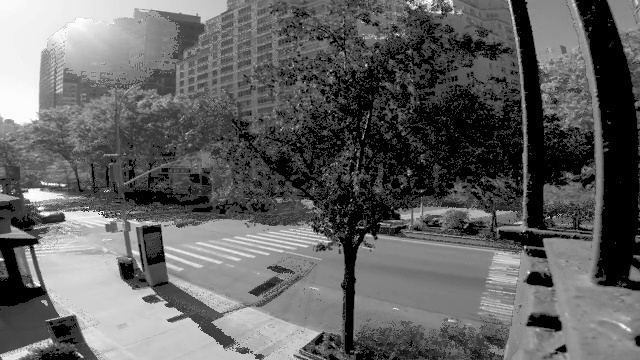

In [ ]:
# Background Image Detected for our own video dataset :
from IPython.display import Image, display
display(Image("data_video_frames/results/data_video_frames/grayscale/background.jpg"))

In [ ]:
# Background Image Detection and storing all yolo detection details for evaluation using CdNet Dataset :
# (Mainly used for analysis and implementation of the paper)
dataset_path = "archive/"
results_path = "archive/results/"

sequences = [
    # "dataset/badWeather/Skating",
    "dataset/dynamicBackground/Fall",
    # "dataset/dynamicBackground/Fountain01",
    # "dataset/shadow/Backdoor",
    # "dataset/shadow/Bungalows"
]
yolo_net, output_layers = load_yolo_model()
process_all_sequences(dataset_path, sequences, results_path, yolo_net, output_layers)

Processing 4000 frames in: archive/dataset/dynamicBackground/Fall\input
Saved detected frame at: archive/results/Fall\grayscale\detections\frame_0299_detected.jpg
Saved detected frame at: archive/results/Fall\grayscale\detections\frame_0300_detected.jpg
Saved detected frame at: archive/results/Fall\grayscale\detections\frame_0301_detected.jpg
Saved detected frame at: archive/results/Fall\grayscale\detections\frame_0302_detected.jpg
Saved detected frame at: archive/results/Fall\grayscale\detections\frame_0303_detected.jpg
Saved detected frame at: archive/results/Fall\grayscale\detections\frame_0304_detected.jpg
Saved detected frame at: archive/results/Fall\grayscale\detections\frame_0305_detected.jpg
Saved detected frame at: archive/results/Fall\grayscale\detections\frame_0306_detected.jpg
Saved detected frame at: archive/results/Fall\grayscale\detections\frame_0307_detected.jpg
Saved detected frame at: archive/results/Fall\grayscale\detections\frame_0308_detected.jpg
Saved detected fra

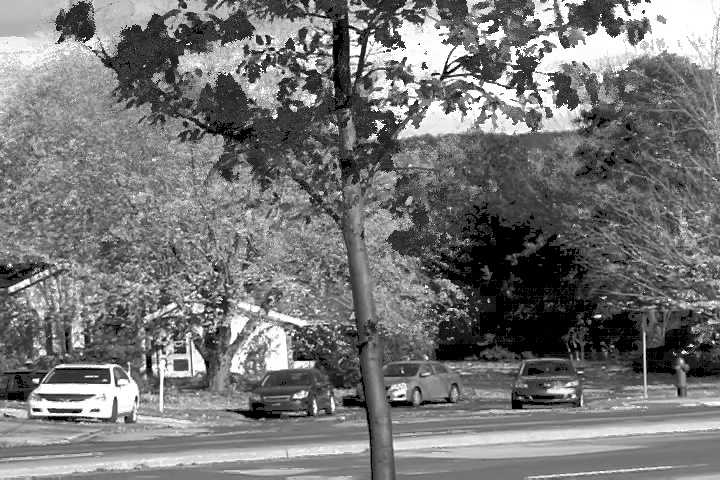

In [ ]:
# Background Image Detected for CdNet dataset :
from IPython.display import Image, display
display(Image("archive/results/Fall/grayscale/background.jpg"))

### Evaluation code for the base paper implementation

In [ ]:
# Note : Only works with CDNet dataset as we have annotated ground truths.

import os
import cv2
import numpy as np

# CONFIG
GT_PATH = "archive/dataset/dynamicBackground/fall/groundtruth"
YOLO_BOXES_DIR = "archive/results/fall/grayscale/boxes"
YOLO_BACKGROUND_TXT = "archive/results/fall/grayscale/background_detections.txt"
IOU_THRESHOLD = 0.5

# METRICS
stats_input = {
    "total_frames": 0,
    "totally_undetectable": 0,
    "some_undetectable": 0,
    "class_misdetection": 0,
    "duplicate_detection": 0,
}
stats_background = {
    "total_background_detections": 0,
    "totally_undetectable": 0,
    "some_undetectable": 0,
    "class_misdetection": 0,
    "duplicate_detection": 0,
}

# UTIL: IOU
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0]+boxA[2], boxB[0]+boxB[2])
    yB = min(boxA[1]+boxA[3], boxB[1]+boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

# UTIL: Load YOLO .txt
def load_yolo_boxes(txt_path):
    if not os.path.exists(txt_path):
        return []
    with open(txt_path, "r") as f:
        return [list(map(int, line.strip().split())) for line in f]

# UTIL: Extract GT boxes from masks
def extract_gt_boxes(gt_path):
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    if gt_mask is None:
        return []
    _, binary = cv2.threshold(gt_mask, 200, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return [cv2.boundingRect(cnt) for cnt in contours]

# COMPARE GT vs Detections
def compare_detections(gt_boxes, det_boxes, stats_dict):
    matched_gt = set()
    matched_det = set()

    for i, gt_box in enumerate(gt_boxes):
        matched = False
        for j, det_box in enumerate(det_boxes):
            iou = compute_iou(gt_box, det_box[:4])
            if iou >= IOU_THRESHOLD:
                if j in matched_det:
                    stats_dict["duplicate_detection"] += 1
                matched_gt.add(i)
                matched_det.add(j)
                matched = True
                break
        if not matched:
            stats_dict["some_undetectable"] += 1

    if len(gt_boxes) > 0 and len(matched_gt) == 0:
        stats_dict["totally_undetectable"] += 1

# MAIN: Per-frame GT vs input YOLO
frame_num = 1
while True:
    gt_filename = os.path.join(GT_PATH, f"gt{frame_num:06d}.png")
    det_filename = os.path.join(YOLO_BOXES_DIR, f"frame_{frame_num:04d}_detected.txt")

    if not os.path.exists(gt_filename):
        break

    gt_boxes = extract_gt_boxes(gt_filename)
    det_boxes = load_yolo_boxes(det_filename)

    stats_input["total_frames"] += 1
    compare_detections(gt_boxes, det_boxes, stats_input)

    frame_num += 1

# FINAL: Background Detection vs All GT Boxes (aggregated)
# We'll compare background detections to all GT boxes (union from above)
background_boxes = load_yolo_boxes(YOLO_BACKGROUND_TXT)
stats_background["total_background_detections"] = len(background_boxes)

# Reset and reprocess GTs for global comparison
all_gt_boxes = []
for i in range(1, frame_num):
    gt_file = os.path.join(GT_PATH, f"gt{i:06d}.png")
    if os.path.exists(gt_file):
        all_gt_boxes.extend(extract_gt_boxes(gt_file))

compare_detections(all_gt_boxes, background_boxes, stats_background)

# PRINT RESULTS
print("\nYOLO on Input Frames (Baseline)")
print("-----------------------------------")
for k, v in stats_input.items():
    print(f"{k.replace('_', ' ').capitalize()}: {v}")

print("\nYOLO on Estimated Background (Proposed)")
print("------------------------------------------")
for k, v in stats_background.items():
    print(f"{k.replace('_', ' ').capitalize()}: {v}")



YOLO on Input Frames (Baseline)
-----------------------------------
Total frames: 4000
Totally undetectable: 228
Some undetectable: 1125
Class misdetection: 0
Duplicate detection: 0

YOLO on Estimated Background (Proposed)
------------------------------------------
Total background detections: 4
Totally undetectable: 0
Some undetectable: 2013
Class misdetection: 0
Duplicate detection: 3


### Improvised Algorithm proposed by our team:

In [ ]:
# Improvised Algorithm Implementation :
import torch
import numpy as np
import cv2
import os

# === Parameters ===
CHANGE_THRESHOLD = 0.1
input_dir = "archive/dataset/dynamicBackground/fall/input/"
bg_path = "archive/results/fall/rgb_results/"
YOLO_CFG = "yolov3.cfg"
YOLO_WEIGHTS = "yolov3.weights"
COCO_NAMES = "coco.names"
IOU_THRESHOLD = 0.5
CONFIDENCE_THRESHOLD = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
standard_size = (640, 360)

# Load YOLO Model
def load_yolo_model():
    net = cv2.dnn.readNet(YOLO_WEIGHTS, YOLO_CFG)
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    return net, output_layers

# YOLO Detection Function
def detect_objects_with_yolo(frame, net, output_layers, save_txt_path=None):
    with open(COCO_NAMES, "r") as f:
        classes = [line.strip() for line in f.readlines()]

    height, width, _ = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    detections = net.forward(output_layers)

    class_ids, confidences, boxes = [], [], []

    for out in detections:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > CONFIDENCE_THRESHOLD:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD, 0.4)
    result_boxes = []
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            cls_id = class_ids[i]
            result_boxes.append((x, y, w, h, cls_id))
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, f"{classes[cls_id]}", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    if save_txt_path is not None:
        with open(save_txt_path, 'w') as f:
            for box in result_boxes:
                f.write(f"{box[0]} {box[1]} {box[2]} {box[3]} {box[4]}\n")

    return frame, result_boxes

# Load YOLO Model Once
net, output_layers = load_yolo_model()

# Prepare Input Frames
frame_files = sorted([f for f in os.listdir(input_dir) if f.endswith(".jpg")])
total_frames = len(frame_files)
OVERLAY_THRESHOLD = min(700, 30 + ((total_frames // 100) * 10))
print(f"Using OVERLAY_THRESHOLD = {OVERLAY_THRESHOLD} for {total_frames} frames")

# Initialize Buffers
overlay_frames = None
background = None
frame_index = 0

# Create output folders
boxes_dir = os.path.join(bg_path, "boxes")
detections_dir = os.path.join(bg_path, "detections")
os.makedirs(boxes_dir, exist_ok=True)
os.makedirs(detections_dir, exist_ok=True)

# Main Loop
for idx, file in enumerate(frame_files):
    frame_path = os.path.join(input_dir, file)
    frame = cv2.imread(frame_path)
    if frame is None:
        continue

    frame_resized = cv2.resize(frame, standard_size)
    frame_tensor = torch.from_numpy(frame_resized).to(device)

    # Save YOLO detection on input frame
    frame_name = f"frame_{idx:04d}"
    txt_save_path = os.path.join(boxes_dir, f"{frame_name}_detected.txt")
    detected_frame, _ = detect_objects_with_yolo(frame_resized.copy(), net, output_layers, save_txt_path=txt_save_path)

    # Save detection image
    detection_img_path = os.path.join(detections_dir, f"{frame_name}_detected.jpg")
    cv2.imwrite(detection_img_path, detected_frame)
    print(f"Saved detected frame at: {detection_img_path}")

    # Background Estimation
    if overlay_frames is None:
        h, w, c = frame_tensor.shape
        overlay_frames = torch.zeros((OVERLAY_THRESHOLD, h, w, c), dtype=torch.uint8, device=device)
        background = torch.zeros((h, w, c), dtype=torch.uint8, device=device)

    overlay_frames[frame_index % OVERLAY_THRESHOLD] = frame_tensor
    frame_index += 1

    if frame_index < OVERLAY_THRESHOLD:
        continue

    dominant_values = torch.mode(overlay_frames, dim=0).values.byte()
    change = (background.to(torch.float32) - dominant_values.to(torch.float32)).abs() / 255.0
    update_mask = change > CHANGE_THRESHOLD
    background[update_mask] = dominant_values[update_mask]

# Save Final Estimated Background
os.makedirs(bg_path, exist_ok=True)
bg_np = background.cpu().numpy()
bg_img_path = os.path.join(bg_path, "background.jpg")
cv2.imwrite(bg_img_path, bg_np)
print(f"Background saved to: {bg_img_path}")

# Run YOLO on Estimated Background
bg_frame = cv2.imread(bg_img_path)
bg_detected_img, _ = detect_objects_with_yolo(
    bg_frame,
    net,
    output_layers,
    save_txt_path=os.path.join(bg_path, "background_detections.txt")
)
cv2.imwrite(os.path.join(bg_path, "background_yolo.jpg"), bg_detected_img)
print(f"YOLO detection on background saved for evaluation.")

Using OVERLAY_THRESHOLD = 430 for 4000 frames
Saved detected frame at: archive/results/fall/rgb_results/detections\frame_0000_detected.jpg
Saved detected frame at: archive/results/fall/rgb_results/detections\frame_0001_detected.jpg
Saved detected frame at: archive/results/fall/rgb_results/detections\frame_0002_detected.jpg
Saved detected frame at: archive/results/fall/rgb_results/detections\frame_0003_detected.jpg
Saved detected frame at: archive/results/fall/rgb_results/detections\frame_0004_detected.jpg
Saved detected frame at: archive/results/fall/rgb_results/detections\frame_0005_detected.jpg
Saved detected frame at: archive/results/fall/rgb_results/detections\frame_0006_detected.jpg
Saved detected frame at: archive/results/fall/rgb_results/detections\frame_0007_detected.jpg
Saved detected frame at: archive/results/fall/rgb_results/detections\frame_0008_detected.jpg
Saved detected frame at: archive/results/fall/rgb_results/detections\frame_0009_detected.jpg
Saved detected frame at:

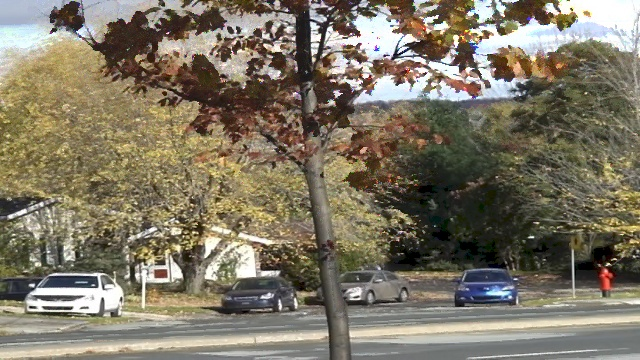

In [ ]:
# Background Image Detected for CdNet dataset :
from IPython.display import Image, display
display(Image("archive/results/fall/rgb_results/background.jpg"))

In [ ]:
# Evaluations run on a our team's improved algorithm code.
import os
import cv2
import numpy as np

# CONFIG
GT_PATH = "archive/dataset/dynamicBackground/fall/groundtruth"
YOLO_BOXES_DIR = "archive/results/fall/rgb_results/boxes"
YOLO_BACKGROUND_TXT = "archive/results/fall/rgb_results/background_detections.txt"
IOU_THRESHOLD = 0.5

# METRICS
stats_input = {
    "total_frames": 0,
    "totally_undetectable": 0,
    "some_undetectable": 0,
    "class_misdetection": 0,
    "duplicate_detection": 0,
}
stats_background = {
    "total_background_detections": 0,
    "totally_undetectable": 0,
    "some_undetectable": 0,
    "class_misdetection": 0,
    "duplicate_detection": 0,
}

# UTIL: IOU
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0]+boxA[2], boxB[0]+boxB[2])
    yB = min(boxA[1]+boxA[3], boxB[1]+boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

# UTIL: Load YOLO .txt
def load_yolo_boxes(txt_path):
    if not os.path.exists(txt_path):
        return []
    with open(txt_path, "r") as f:
        return [list(map(int, line.strip().split())) for line in f]

# UTIL: Extract GT boxes from masks
def extract_gt_boxes(gt_path):
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    if gt_mask is None:
        return []
    _, binary = cv2.threshold(gt_mask, 200, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return [cv2.boundingRect(cnt) for cnt in contours]

# COMPARE GT vs Detections
def compare_detections(gt_boxes, det_boxes, stats_dict):
    matched_gt = set()
    matched_det = set()

    for i, gt_box in enumerate(gt_boxes):
        matched = False
        for j, det_box in enumerate(det_boxes):
            iou = compute_iou(gt_box, det_box[:4])
            if iou >= IOU_THRESHOLD:
                if j in matched_det:
                    stats_dict["duplicate_detection"] += 1
                matched_gt.add(i)
                matched_det.add(j)
                matched = True
                break
        if not matched:
            stats_dict["some_undetectable"] += 1

    if len(gt_boxes) > 0 and len(matched_gt) == 0:
        stats_dict["totally_undetectable"] += 1

# MAIN: Per-frame GT vs input YOLO
frame_num = 1
while True:
    gt_filename = os.path.join(GT_PATH, f"gt{frame_num:06d}.png")
    det_filename = os.path.join(YOLO_BOXES_DIR, f"frame_{frame_num-1:04d}_detected.txt")  # 0-based index

    if not os.path.exists(gt_filename):
        break

    gt_boxes = extract_gt_boxes(gt_filename)
    det_boxes = load_yolo_boxes(det_filename)

    stats_input["total_frames"] += 1
    compare_detections(gt_boxes, det_boxes, stats_input)

    frame_num += 1

# FINAL: Background Detection vs All GT Boxes (aggregated)
background_boxes = load_yolo_boxes(YOLO_BACKGROUND_TXT)
stats_background["total_background_detections"] = len(background_boxes)

# Re-accumulate all ground truth boxes
all_gt_boxes = []
for i in range(1, frame_num):
    gt_file = os.path.join(GT_PATH, f"gt{i:06d}.png")
    if os.path.exists(gt_file):
        all_gt_boxes.extend(extract_gt_boxes(gt_file))

compare_detections(all_gt_boxes, background_boxes, stats_background)

# PRINT RESULTS
print("\nYOLO on Input Frames (Baseline RGB)")
print("----------------------------------------")
for k, v in stats_input.items():
    print(f"{k.replace('_', ' ').capitalize()}: {v}")

print("\nYOLO on Estimated RGB Background (Proposed)")
print("-----------------------------------------------")
for k, v in stats_background.items():
    print(f"{k.replace('_', ' ').capitalize()}: {v}")


YOLO on Input Frames (Baseline RGB)
----------------------------------------
Total frames: 4000
Totally undetectable: 1093
Some undetectable: 2017
Class misdetection: 0
Duplicate detection: 0

YOLO on Estimated RGB Background (Proposed)
-----------------------------------------------
Total background detections: 6
Totally undetectable: 1
Some undetectable: 2017
Class misdetection: 0
Duplicate detection: 0


### Calculating metrics like PSNR, SSIM, Precision, Recall and F1 scores comparing both the detections and outputs.

In [ ]:
# Modify or update the paths as per the dataset we use.
import os
import cv2
import numpy as np
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Configuration
GT_PATH = "archive/dataset/dynamicBackground/fall/groundtruth"
GRAY_BG_IMG = "archive/results/fall/grayscale/background.jpg"
GRAY_YOLO_TXT = "archive/results/fall/background_detections.txt"
RGB_BG_IMG = "archive/results/fall/rgb_results/background.jpg"
RGB_YOLO_TXT = "archive/results/fall/rgb_results/background_detections.txt"
IOU_THRESHOLD = 0.5
RESIZE_TO = (640, 360)

# Utility Functions
def load_yolo_boxes(txt_path):
    if not os.path.exists(txt_path):
        return []
    with open(txt_path, "r") as f:
        return [list(map(int, line.strip().split())) for line in f]

def extract_gt_boxes(gt_img):
    _, binary = cv2.threshold(gt_img, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return [cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > 100]

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / float(boxAArea + boxBArea - interArea + 1e-5)

def evaluate(background_path, detection_txt, method_label):
    bg_img = cv2.imread(background_path)
    if bg_img is None:
        return {"method": method_label, "ssim": -1, "psnr": -1, "precision": -1, "recall": -1, "f1": -1}
    bg_resized = cv2.resize(bg_img, RESIZE_TO)
    bg_gray = cv2.cvtColor(bg_resized, cv2.COLOR_BGR2GRAY)

    gt_mid_path = os.path.join(GT_PATH, "gt000300.png")
    gt_img = cv2.imread(gt_mid_path, cv2.IMREAD_GRAYSCALE)
    if gt_img is None:
        return {"method": method_label, "ssim": -1, "psnr": -1, "precision": -1, "recall": -1, "f1": -1}
    gt_img = cv2.resize(gt_img, RESIZE_TO)
    gt_boxes = extract_gt_boxes(gt_img)

    pred_boxes = load_yolo_boxes(detection_txt)

    matched = set()
    TP = FP = 0
    for pred in pred_boxes:
        found = False
        for i, gt in enumerate(gt_boxes):
            if i in matched: continue
            if compute_iou(pred[:4], gt) > IOU_THRESHOLD:
                TP += 1
                matched.add(i)
                found = True
                break
        if not found:
            FP += 1
    FN = len(gt_boxes) - len(matched)
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    return {
        "method": method_label,
        "ssim": round(ssim(gt_img, bg_gray), 4),
        "psnr": round(psnr(gt_img, bg_gray), 2),
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1": round(f1, 4)
    }

# Run Evaluation for Grayscale and RGB
results = [
    evaluate(GRAY_BG_IMG, GRAY_YOLO_TXT, "Grayscale"),
    evaluate(RGB_BG_IMG, RGB_YOLO_TXT, "RGB")
]

df_metrics = pd.DataFrame(results)
df_metrics


,method,ssim,psnr,precision,recall,f1
0,Grayscale,0.1266,11.33,0.0,0,0
1,RGB,0.1435,11.47,0.0,0,0
